In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

In [4]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 128
strides = 1
input_size = 100
lr=0.0005

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, n_grid+1, n_grid+1))

In [14]:
image = 1-image/100

In [15]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [16]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [17]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [18]:
y = y.reshape((133, 16, 2, 1))

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [21]:
geometry.shape

(2128, 1)

In [22]:
geometry = geometry.reshape((133, 16, 1))

In [23]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [24]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [25]:
x_train.shape

(2016, 129, 129, 1)

In [26]:
#with mirrored_strategy.scope():
input_image = tf.keras.Input(shape=(n_grid+1, n_grid+1, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [27]:
#with mirrored_strategy.scope():
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 129, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 129, 129, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 100)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 409600)            0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               81920200  
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [28]:
#with mirrored_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [29]:
#with mirrored_strategy.scope():
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 4s 18ms/step - loss: 9.7168 - rmse: 3.1172
Epoch 2/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2243 - rmse: 0.4736
Epoch 3/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2238 - rmse: 0.4731
Epoch 4/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2283 - rmse: 0.4778
Epoch 5/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2234 - rmse: 0.4726
Epoch 6/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2303 - rmse: 0.4798
Epoch 7/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2194 - rmse: 0.4684
Epoch 8/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2448 - rmse: 0.4947
Epoch 9/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.2240 - rmse: 0.4733
Epoch 10/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.1979 - rmse: 0.4448
Epoch 11/5000
63/63 [========

63/63 [==============================] - 1s 18ms/step - loss: 0.0067 - rmse: 0.0819
Epoch 85/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0066 - rmse: 0.0815
Epoch 86/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0065 - rmse: 0.0807
Epoch 87/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0062 - rmse: 0.0789
Epoch 88/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0069 - rmse: 0.0829
Epoch 89/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0066 - rmse: 0.0815
Epoch 90/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0072 - rmse: 0.0849
Epoch 91/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0065 - rmse: 0.0807
Epoch 92/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0065 - rmse: 0.0805
Epoch 93/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0064 - rmse: 0.0800
Epoch 94/5000
63/63 [=============

63/63 [==============================] - 1s 18ms/step - loss: 0.0054 - rmse: 0.0735
Epoch 168/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0053 - rmse: 0.0728
Epoch 169/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0053 - rmse: 0.0727
Epoch 170/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 171/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0053 - rmse: 0.0725
Epoch 172/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0047 - rmse: 0.0685
Epoch 173/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0049 - rmse: 0.0702
Epoch 174/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0048 - rmse: 0.0694
Epoch 175/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0050 - rmse: 0.0705
Epoch 176/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0048 - rmse: 0.0696
Epoch 177/5000
63/63 [===

63/63 [==============================] - 1s 18ms/step - loss: 0.0035 - rmse: 0.0591
Epoch 250/5000
63/63 [==============================] - 1s 17ms/step - loss: 0.0034 - rmse: 0.0581
Epoch 251/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0033 - rmse: 0.0577
Epoch 252/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0036 - rmse: 0.0597
Epoch 253/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0031 - rmse: 0.0560
Epoch 254/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0040 - rmse: 0.0631
Epoch 255/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0033 - rmse: 0.0577
Epoch 256/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0033 - rmse: 0.0571
Epoch 257/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0033 - rmse: 0.0578
Epoch 258/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0030 - rmse: 0.0550
Epoch 259/5000
63/63 [===

63/63 [==============================] - 1s 17ms/step - loss: 0.0047 - rmse: 0.0688
Epoch 332/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0044 - rmse: 0.0663
Epoch 333/5000
63/63 [==============================] - 1s 17ms/step - loss: 0.0046 - rmse: 0.0680
Epoch 334/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0044 - rmse: 0.0662
Epoch 335/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0048 - rmse: 0.0690
Epoch 336/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0044 - rmse: 0.0664
Epoch 337/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0043 - rmse: 0.0654
Epoch 338/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0041 - rmse: 0.0643
Epoch 339/5000
63/63 [==============================] - 1s 18ms/step - loss: 0.0043 - rmse: 0.0658
Epoch 340/5000
63/63 [==============================] - 1s 17ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 341/5000
63/63 [===

In [30]:
time = end - start
print("Training time:", time)

Training time: 0:07:25.573853


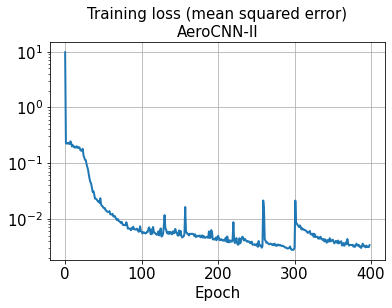

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

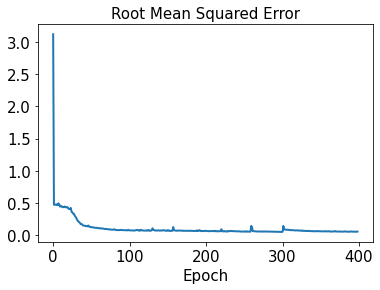

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

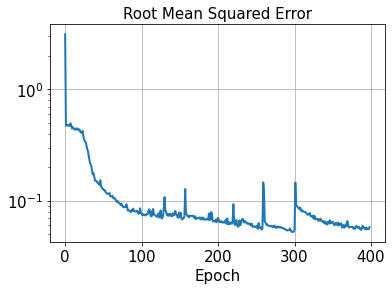

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [34]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 3ms/step - loss: 1.8814e-06 - rmse: 0.0000e+00


In [35]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

63/63 [==============================] - 0s 4ms/step


In [36]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 10ms/step


In [37]:
error_train_abs = np.abs(decoded_train - y_train)

In [38]:
error_test_abs = np.abs(decoded_test - y_test)

In [39]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [40]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [41]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [42]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [43]:
os.chdir("D:\\TrainedModels\\20221024")
model.save('AeroCNN-II_ClCd_nGrid128_100kernel_2by2MaxPooling_1CNNlayer_testSize0.05(lr0.0005).h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.10055676398163223


In [45]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.08146281536096094


In [46]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.09907617426402159


In [47]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.13367658884887082


In [48]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.08166661150672162


In [49]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.07585908773700993


In [50]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.07483054146810379, 0.08900431711919633, 0.06082741234521158, 0.017852124782719844, 0.2931000564430608, 0.774482204140271, 0.04782531728149264, 0.2247573385307277, 0.057130009523506595, 0.0893198561902508, 0.23005023674146252, 0.02636010161978773, 0.019139507296767437, 0.03589357813365726, 0.020732130428864036, 0.04192686044232414, 0.13816812261721978, 0.15509907781925955, 0.09256288685293697, 0.30700700205667303, 1.0535686295490179, 1.3171078148422355, 0.2659824100419314, 0.13442148305040832, 0.1283031188222465, 0.021962222886339425, 0.09392633678891509, 0.020035060062444363, 0.011574192657691355, 0.0632429442632047, 0.007189896734141718, 0.030270280161961486, 0.1554093671114791, 0.0394616293737098, 0.1837623042758882, 0.27042606573549605, 3.269596607226164, 1.072306950785573, 0.36091170464682654, 0.14330160409694104, 0.15579984213760792, 0.09967929158760588, 0.13215524350901128, 0.09006122982944442, 0.02567161764927455, 0.043116382558012, 0.030872728586763164, 0.11915672449353229, 

In [51]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.06264885681864728, 0.09506216848470349, 0.09069873177963228, 0.09776394487307652, 0.6526752146885633, 0.7584146973746636, 0.264609242437459, 0.06802897832132926, 0.06307095329233539, 0.09204457792438332, 0.11564809498613188, 0.014901598572664147, 0.06123723960668326, 0.03812442499870163, 0.011432545716782158, 0.036472014942184675, 0.10761136385150108, 0.14417287041395263, 0.1117869143545789, 0.3814508025025796, 4.5713001901390715, 0.04158660559661527, 0.02509676087058673, 0.043470195087147986, 0.021478024869105248, 0.010445009380511912, 0.014347301904939679, 0.0053655279194271, 0.012437449111843099, 0.020781870410454064, 0.0859899112524018, 0.0274456970519243, 0.08344784621853328, 0.023395642876930935, 0.11350242219565387, 0.06859953071601539, 0.6065080010073357, 1.1982825055843007, 0.1819625172409722, 0.00903502904065545, 0.012471976863818665, 0.1016739445787774, 0.3342430047903183, 0.023970331129498944, 0.18749600454233104, 0.032691261396060746, 0.028288682805259344, 0.07637552847

In [52]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.0677243117423439, 0.08454860680454229, 0.06101321964552784, 0.002040207665966924, 0.29117605339595487, 0.7867968675402646, 0.04528570239347577, 0.2204801796358899, 0.050609126975154836, 0.08916912935378715, 0.23098151074974135, 0.025108114549127137, 0.007495627093385366, 0.012828376957970986, 0.004479896049128292, 0.04304506609093547, 0.11184883409768297, 0.15439486933573965, 0.09062174636687705, 0.3063897301014683, 1.058062132320046, 1.3440999343788735, 0.26538864007704566, 0.1331686334631711, 0.12745439923373383, 0.01769615457795776, 0.09564206696508303, 0.008848031318579534, 0.012013577466336661, 0.06254643340228608, 0.0019730827673629164, 0.03265186918690718, 0.15922103688645556, 0.03738333733858262, 0.18376327451204325, 0.27068542108942867, 3.410120389403607, 1.0757301579809082, 0.35985110364094225, 0.14324817690092825, 0.15582152452343556, 0.09909793260036362, 0.13196800888244187, 0.08950279561922869, 0.020310636975118646, 0.04461276420003135, 0.032696136500604454, 0.126750131

In [53]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.15650884956057462, 0.1840270644080549, 0.0038393562657478325, 0.39781307239445124, 0.4919050922634789, 0.5078551521611466, 0.3064710235202933, 1.372609025217203, 0.9527619540168737, 0.14815061175767105, 0.1260698139363165, 0.0432875632821233, 0.06534972961269268, 0.10943628009715287, 0.0602518271082495, 0.03190310345907555, 0.3948886147102897, 0.395896826193065, 0.5647425792203287, 0.5387326544304193, 0.3335784191989277, 0.4783090570074843, 0.426172413956116, 0.5596555315855106, 0.5129451768776462, 0.298442946425348, 0.02903964417312514, 0.07801341971904402, 0.004059227939489276, 0.0694398813169221, 0.0215312906610926, 0.0069318033502622665, 0.040820426822944136, 0.09854059252187437, 0.1832498436061964, 0.1843282140111809, 0.20375605737438032, 0.1315546731890467, 0.8235675257426257, 0.2058312775067424, 0.10535497163901045, 0.4983487244955647, 0.32035036855944854, 0.34054564311651137, 0.06757972491204682, 0.02127801739717923, 0.009114126171674088, 0.013284163999117093, 0.014707555899

In [54]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.20375605737438032

In [55]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.05846880258755107, 0.0877841746191283, 0.0909529578530905, 0.09698983682715782, 0.6550839632997659, 0.7705992997449421, 0.26491287718566553, 0.0660645766703821, 0.061534600040139664, 0.09224392555340902, 0.11732237988014793, 0.005695026284263635, 0.06076891138374999, 0.029567750232696345, 0.006161744210747149, 0.016779295325388747, 0.10749229629255541, 0.14406168571279127, 0.11182226533513151, 0.38237509233567046, 6.587013902273253, 0.040136771972496044, 0.0251116331754436, 0.04331073954077077, 0.0214519477081165, 0.0067351078162698605, 0.009939890454385014, 0.004229203937350698, 0.01229686745483163, 0.01738638757060411, 0.07697671670593487, 0.025812495214042563, 0.08185354286195831, 0.018517705099691483, 0.11371497715703656, 0.06811736248158423, 0.6086768927013251, 1.22121905562556, 0.17994585285213463, 0.008978983826134755, 0.002739622587405402, 0.10166593370195941, 0.3363096853214166, 0.024171729253428875, 0.19401248472131036, 0.00419683280283068, 0.0277385419132868, 0.0815305928

In [56]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.11663076308630171, 0.23678150638095277, 0.004345328996243129, 0.2525471117089427, 0.3523431841897424, 0.29316750396757685, 0.0550742653172764, 0.471978743872226, 0.34051163949245816, 0.03672536725367432, 0.03348234462006845, 0.0603951062172507, 0.06693726516983274, 0.08387360064932273, 0.03011334045592206, 0.09032414750103115, 0.18812147176974817, 0.2213993082413132, 0.0891786868773967, 0.096969488651335, 0.003722881480072275, 0.14483419031215775, 0.012013381514821059, 0.13873600109563528, 0.04842056482448377, 0.3332671594764433, 0.3913104510009249, 0.09832151541069263, 0.03744873129701232, 0.1161738348104407, 0.20558957332537733, 0.0350788439478984, 0.1083136932324371, 0.0937430058276077, 0.03993979680414005, 0.18699347961516075, 0.2544594098024376, 0.2909316109651978, 0.5743534041158386, 0.03232432022895123, 0.40747250101509463, 0.10512783222852033, 0.07918805963360366, 0.019664566974137886, 0.01904286937805123, 0.11471852618266747, 0.03273282299160441, 0.007291408339806484, 0.185

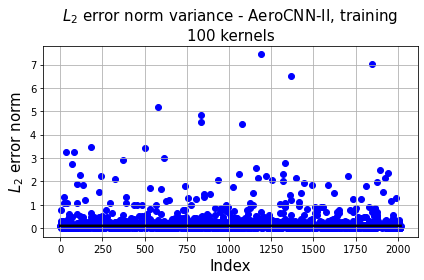

In [57]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

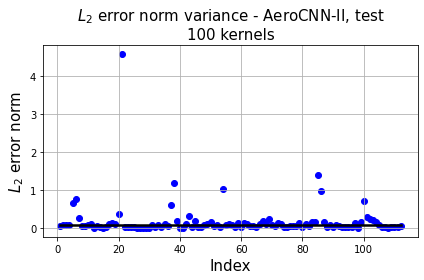

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

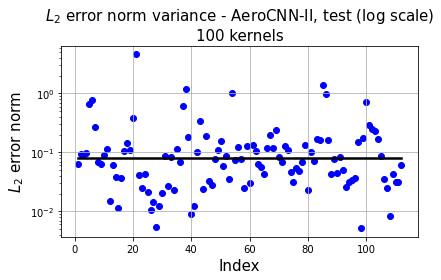

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

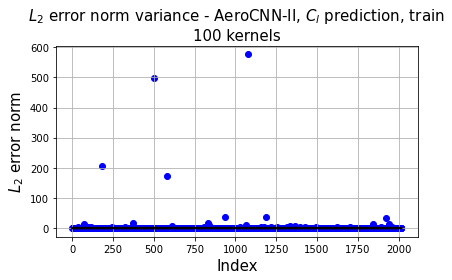

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

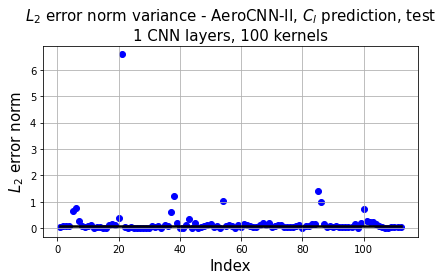

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

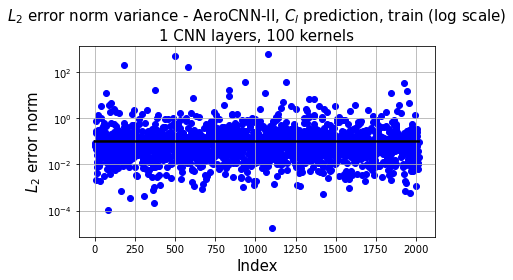

In [62]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

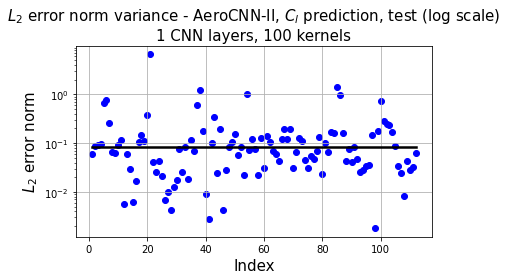

In [63]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

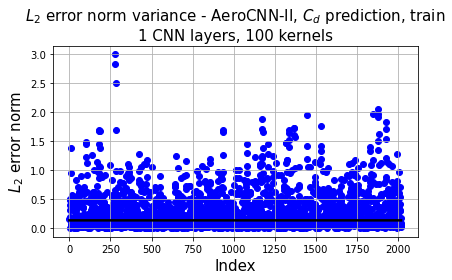

In [64]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

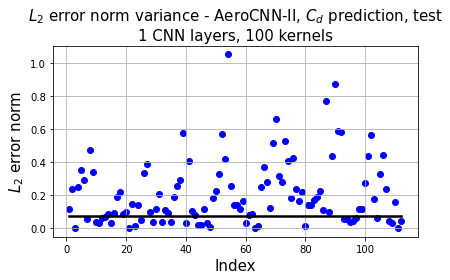

In [65]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

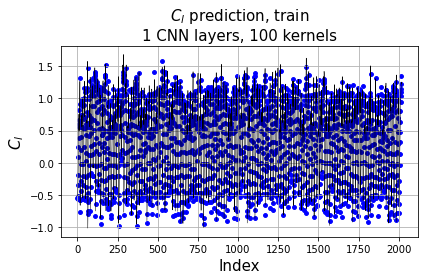

In [66]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

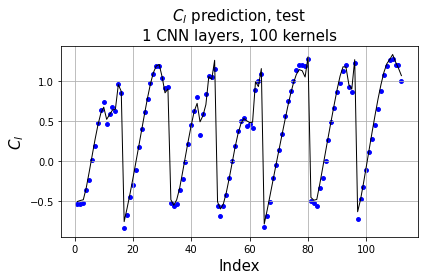

In [67]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

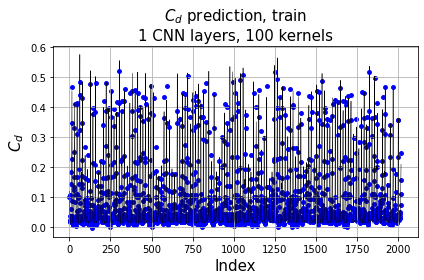

In [68]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

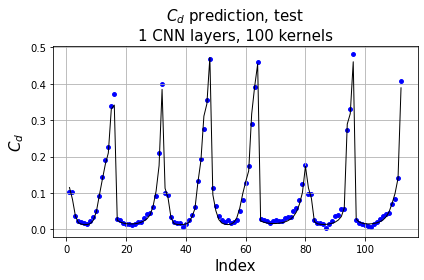

In [69]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

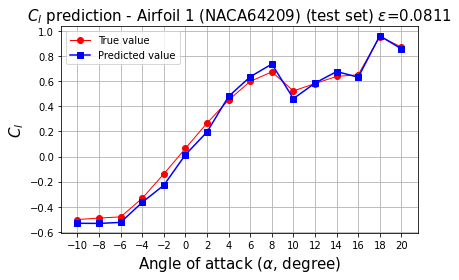

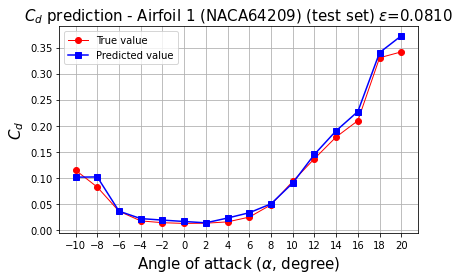

In [70]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

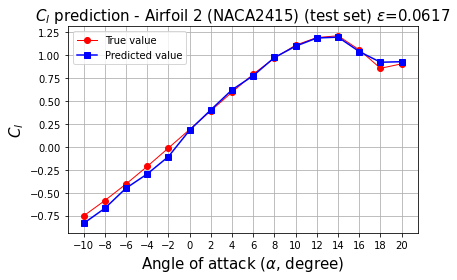

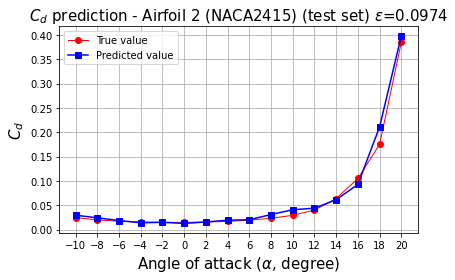

In [71]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

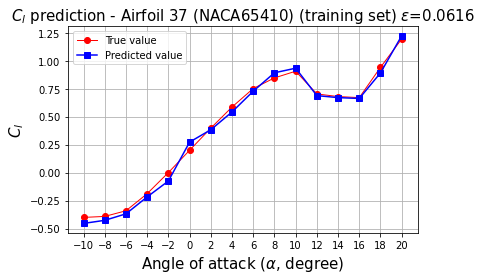

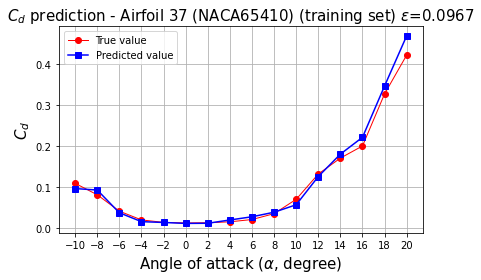

In [72]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

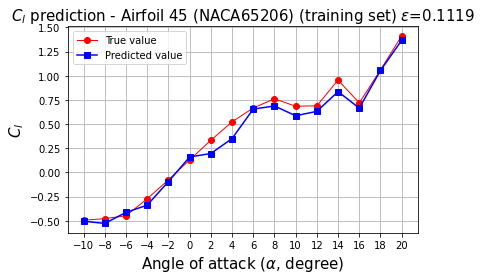

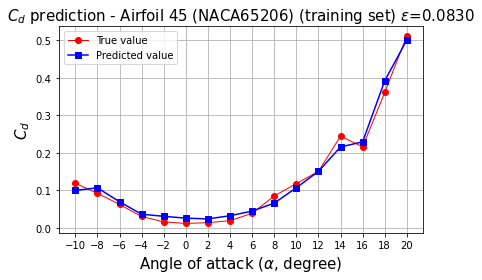

In [73]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

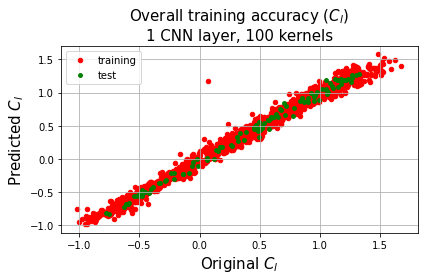

In [74]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

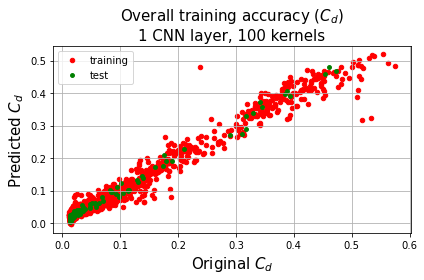

In [75]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

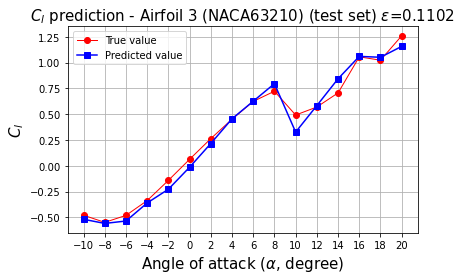

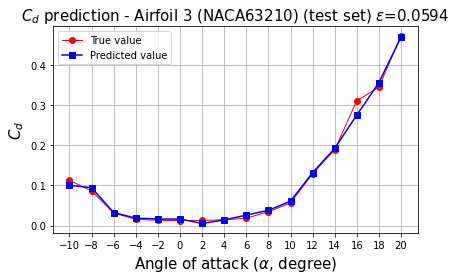

In [76]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

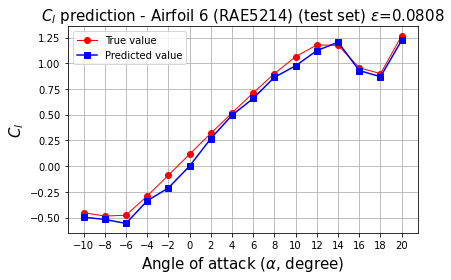

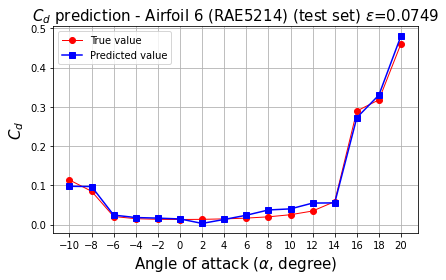

In [77]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()